In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
from scipy.stats import ttest_ind
from numba import njit, jit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from scipy.stats import entropy

In [2]:
meta = pd.read_csv('../data/reduced/meta_01.csv')
print(meta['plat'].unique())
meta.head()

FileNotFoundError: [Errno 2] File ../data/reduced/meta_01.csv does not exist: '../data/reduced/meta_01.csv'

In [ ]:
data = pd.read_csv('../data/reduced/DESeq2_01.csv')
data.columns = meta['CN']
data = data.astype(float).T

In [ ]:
data.head()

In [ ]:
Z = hierarchy.linkage(data, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)

In [7]:
tree = hierarchy.to_tree(Z)
head_id = tree.id

def find_children(tree):
    values = tree.pre_order(lambda x: x.id)
    pair = {head_id - tree.id: values}
    
    if not tree.left.is_leaf():
        pair.update(find_children(tree.left))
    if not tree.right.is_leaf():
        pair.update(find_children(tree.right))
        
    return pair

child_clusters = find_children(tree)

In [62]:
tree.right.is_leaf()

False

In [71]:
def find_subclusters(tree):
    pair = {head_id - tree.id: []}
    
    if not tree.left.is_leaf():
        pair[head_id - tree.id].append(head_id - tree.left.id)
        pair.update(find_subclusters(tree.left))
    else:
        pair[head_id - tree.id].append(None)
    if not tree.right.is_leaf():
        pair[head_id - tree.id].append(head_id - tree.right.id)
        pair.update(find_subclusters(tree.right))
    else:
        pair[head_id - tree.id].append(None)
        
    return pair

subcluster_clusters = find_subclusters(tree)

In [72]:
label_clusters = {k: meta.iloc[v]['plat'].values for k, v in child_clusters.items()}

In [73]:
def calc_entropy(labels):
    counts = np.unique(labels, return_counts=True)[1]
    return entropy(counts)

entropy_clusters = {k: calc_entropy(v) for k, v in label_clusters.items()}

In [111]:
k = 1
a = 2
- k/a * np.log(k/a) - (1 - k/a) * np.log(1 - k/a)

0.6931471805599453

In [134]:
def information_gain(parent, left, right):
    if entropy_clusters[parent] == 0:
        return 1
    
    N = len(child_clusters[parent])

    if left is not None:
        n_l = len(child_clusters[left])
        entropy_l = entropy_clusters[left]
    else:
        n_l = 1
        entropy_l = 0
        
    if right is not None:
        n_r = len(child_clusters[right])
        entropy_r = entropy_clusters[right]
    else:
        n_r = 1
        entropy_r = 0
    print(entropy_clusters[parent], entropy_l, entropy_r, n_l / N * entropy_l / entropy_clusters[parent], n_r / N * entropy_r / entropy_clusters[parent])
    return 1 - (n_l / N * entropy_l / entropy_clusters[parent] + n_r / N * entropy_r / entropy_clusters[parent])

ig_clusters = {k: information_gain(k, left, right) for k, (left, right) in subcluster_clusters.items()}

1.602803189007172 0 1.607690041513806 0.0 0.9961787428661365
1.607690041513806 0.0 1.4572341436122 0.0 0.843903490176925
1.4572341436122 0 1.4618959856016887 0.0 0.9957679984440732
1.4618959856016887 0 1.466554400570078 0.0 0.995700090212524
1.466554400570078 0 1.4712074438570384 0.0 0.995630119950043
1.4712074438570384 0 1.4758530354233697 0.0 0.9955579933511285
1.4758530354233697 0 1.4804889502588567 0.0 0.9954836102424054
1.4804889502588567 0.0 1.489722061752916 0.0 0.9907559664976949
1.489722061752916 0 1.4943139858283225 0.0 0.9952458219417496
1.4943139858283225 1.2567611867145763 0.0 0.7085833695209204 0.0
1.2567611867145763 0 1.2615779496646051 0.0 0.9944510657622165
1.2615779496646051 0 1.2663858201818625 0.0 0.994341082511713
1.2663858201818625 0.0 0.9905025934219388 0.0 0.6629645180170544
0.9905025934219388 0 0.9949236325717752 0.0 0.9931773242039433
0.9949236325717752 0.0 0.5623351446188083 0.0 0.41105769415796894
0.5623351446188083 0.5936148767694077 0.0 0.9401657617916396 

In [135]:
len(ig_clusters)

145

In [136]:
a, b = list(zip(*sorted(list(ig_clusters.items()))))

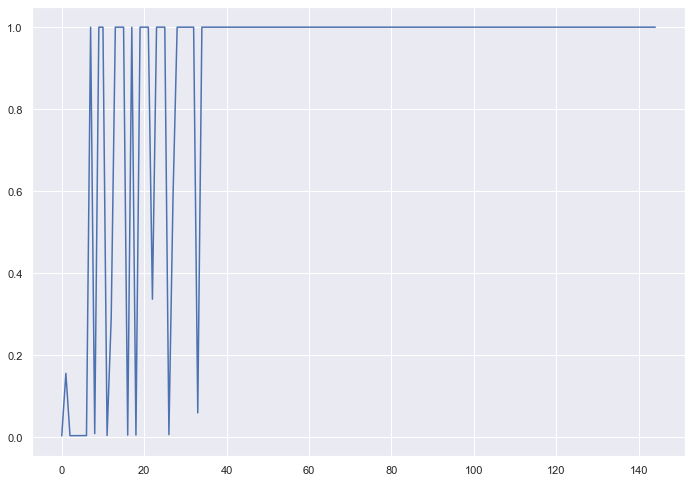

In [137]:
plt.plot(a, b)